# Model Comparison: Lead Price 7-Day Return Prediction (4 Pure Price Features)

This notebook compares the performance of all regression models on predicting 7-day returns of lead prices using 4 pure price features (baseline model).

**Note:** This notebook uses `all_features_with_macro.csv` as the data source to ensure the same data rows as the `model_comparision_reg_withMacro.ipynb` notebook, but only uses 4 pure price features for fair comparison.

## Features Used (4 Pure Price Features):
These features are selected from the Top 20 PCA features identified in EDA, representing the most important pure price-derived features:
1. returns
2. RSI
3. MACD30
4. rolling_volatility

## Models Included:
1. Linear Regression
2. Ridge Regression
3. Random Forest
4. XGBoost
5. LSTM
6. Transformer
7. ARIMA
8. SARIMA


In [55]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Add project root to Python path
try:
    current_dir = Path.cwd()
    if current_dir.name == 'notebooks':
        project_root = current_dir.parent
    else:
        project_root = current_dir
except:
    project_root = Path(r'C:\Project_Macro_Impact_On_Lead')

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

os.chdir(project_root)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Import data splitting function
from src.data.train_test_split_walk_forward import train_test_split_time_series

# Import all regression models
from src.regression.reg_baseline_linear import train_linear_regression, train_ridge_regression
from src.regression.reg_tree_models import train_random_forest, train_xgboost
from src.regression.reg_lstm import train_lstm
from src.regression.reg_transformer import train_transformer
from src.regression.reg_time_series import train_arima, train_sarima

print("All imports successful")


All imports successful


In [56]:
# Load data - using all_features_with_macro.csv to ensure same data rows as withMacro notebook
# But we will only use 4 pure price features for this baseline model
df = pd.read_csv("data_processed/all_features_with_macro.csv", index_col=0, parse_dates=True)

print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()


Data shape: (6110, 39)
Columns: ['LOPBDY LME Comdty', 'returns', 'MA7', 'MA30', 'rolling_volatility', 'EMA5', 'EMA15', 'EMA30', 'MACD5', 'MACD15', 'MACD30', 'RSI', 'BB_upper', 'BB_middle', 'BB_lower', 'return_7d', 'target', 'future_return', 'future_MA7', 'future_MA30', 'future_rolling_volatility', 'future_return_7d', 'dxy_return_7d', 'yield_change_7d', 'dxy_ma_diff_20_5', 'copper_return_7d', 'wti_return_7d', 'lead_to_copper_ratio', 'copper_ma_diff_20_5', 'copper_vol_7d', 'wti_vol_7d', 'corr_lead_copper_30d', 'corr_lead_dxy_30d', 'IDF', 'divergence_lc', 'oil_dxy_interaction', 'joint_momentum', 'regime_dxy_yield', 'unreason']


,LOPBDY LME Comdty,returns,MA7,MA30,rolling_volatility,EMA5,EMA15,EMA30,MACD5,MACD15,...,copper_vol_7d,wti_vol_7d,corr_lead_copper_30d,corr_lead_dxy_30d,IDF,divergence_lc,oil_dxy_interaction,joint_momentum,regime_dxy_yield,unreason
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-22,484.0,0.016807,466.642857,465.850000,0.016046,472.477942,468.758402,466.470573,5.445235,1.725695,...,0.021711,0.024679,0.227243,-0.225959,0.053504,0.000993,0.000293,0.045518,1,509
2001-01-23,494.0,0.020661,470.428571,466.750000,0.016374,479.651961,471.913602,468.246665,10.621677,2.883317,...,0.021711,0.041656,0.217905,-0.193981,0.012298,0.037864,0.000027,0.082308,1,509
2001-01-24,490.5,-0.007085,473.857143,467.533333,0.016455,483.267974,474.236902,469.682364,12.647340,3.616268,...,0.021846,0.041362,0.227842,-0.223879,-0.019303,0.054526,-0.000706,0.043869,1,509
2001-01-25,489.0,-0.003058,479.000000,468.383333,0.016389,485.178650,476.082289,470.928663,13.196581,4.100221,...,0.019527,0.041402,0.233019,-0.223084,-0.007825,0.062501,-0.000444,0.096440,1,509
2001-01-26,500.0,0.022495,485.642857,469.933333,0.016184,490.119100,479.072003,472.804234,16.061629,5.014532,...,0.019397,0.040938,0.239768,-0.214631,0.006702,0.093516,0.000026,0.111556,1,509


In [57]:
# Prepare features and target variable
# Using 4 pure price features (baseline model)
# Selected from Top 20 PCA features - these are the pure price features that appear in the top 20
# Note: Using all_features_with_macro.csv to ensure same data rows as withMacro notebook
feature_cols = ['returns', 'RSI', 'MACD30', 'rolling_volatility']
target_col = 'LOPBDY LME Comdty'

# Extract features (X) - exclude target variables and irrelevant columns
irr_cols = ['LOPBDY LME Comdty', 'return_7d', 'target', 'Date', 'Security']
X = df.drop(columns=irr_cols, errors='ignore')

# Select only the 4 pure price features that exist in the dataframe
feature_cols_available = [f for f in feature_cols if f in X.columns]
print(f"Available features from 4 pure price features: {len(feature_cols_available)}/{len(feature_cols)}")
missing_features = [f for f in feature_cols if f not in X.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")

X = X[feature_cols_available].values
y = df[target_col].values

# Handle missing values
valid_mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
X = X[valid_mask]
y = y[valid_mask]

print(f"\nProcessed data shape: X={X.shape}, y={y.shape}")
print(f"Features used ({len(feature_cols_available)}): {feature_cols_available}")
print(f"Missing values removed: {len(df) - len(X)} rows")


Available features from 4 pure price features: 4/4

Processed data shape: X=(6110, 4), y=(6110,)
Features used (4): ['returns', 'RSI', 'MACD30', 'rolling_volatility']
Missing values removed: 0 rows


In [58]:
# Time series train-test split
train_X, train_y, test_X, test_y = train_test_split_time_series(X, y, test_size=0.2)

# For fair comparison, align test sets to match LSTM/Transformer requirements
# LSTM/Transformer need seq_length samples to create sequences, so they skip first (seq_length-1) test samples
seq_length = 10  # Match the seq_length used in LSTM/Transformer
test_X_aligned = test_X[seq_length - 1:]
test_y_aligned = test_y[seq_length - 1:]

print(f"Training set size: {len(train_X)}")
print(f"Original test set size: {len(test_X)}")
print(f"Aligned test set size (for fair comparison): {len(test_X_aligned)}")
print(f"Skipped first {seq_length - 1} test samples to align with sequence models")
print(f"Train/Test ratio: {len(train_X)/len(test_X_aligned):.2f}:1")


Training set size: 4888
Original test set size: 1222
Aligned test set size (for fair comparison): 1213
Skipped first 9 test samples to align with sequence models
Train/Test ratio: 4.03:1


## Run All Models

This cell trains all models and collects their results.


## Optional: Find Best ARIMA/SARIMA Parameters

Run the cell below once to find the best parameters for ARIMA and SARIMA models.
The results will show the optimal `order` and `seasonal_order` parameters.
Then update the parameters in the main training cell above to use these best parameters.


In [59]:
"""
# Run this cell once to find the best ARIMA and SARIMA parameters
# After getting the results, update the parameters in the main training cell above
# NOTE: This will take several minutes. You only need to run it once.

print("Finding best ARIMA parameters (this may take a few minutes)...")
print("=" * 80)
arima_result = train_arima(train_X, train_y, test_X_aligned, test_y_aligned, auto_select=True)
print(f"\n✓ Best ARIMA order: {arima_result['order']}")
print(f"  RMSE: {arima_result['rmse']:.6f}, MAE: {arima_result['mae']:.6f}")

print("\n" + "=" * 80)
print("Finding best SARIMA parameters (this may take longer, ~5-10 minutes)...")
print("=" * 80)
sarima_result = train_sarima(train_X, train_y, test_X_aligned, test_y_aligned, 
                             seasonal_periods=12, auto_select=True)
print(f"\n✓ Best SARIMA order: {sarima_result['order']}")
print(f"✓ Best SARIMA seasonal_order: {sarima_result['seasonal_order']}")
print(f"  RMSE: {sarima_result['rmse']:.6f}, MAE: {sarima_result['mae']:.6f}")

print("\n" + "=" * 80)
print("Copy these parameters to the main training cell above:")
print(f"ARIMA: order={arima_result['order']}")
print(f"SARIMA: order={sarima_result['order']}, seasonal_order={sarima_result['seasonal_order']}")
print("=" * 80)
"""

'\n# Run this cell once to find the best ARIMA and SARIMA parameters\n# After getting the results, update the parameters in the main training cell above\n# NOTE: This will take several minutes. You only need to run it once.\n\nprint("Finding best ARIMA parameters (this may take a few minutes)...")\nprint("=" * 80)\narima_result = train_arima(train_X, train_y, test_X_aligned, test_y_aligned, auto_select=True)\nprint(f"\n✓ Best ARIMA order: {arima_result[\'order\']}")\nprint(f"  RMSE: {arima_result[\'rmse\']:.6f}, MAE: {arima_result[\'mae\']:.6f}")\n\nprint("\n" + "=" * 80)\nprint("Finding best SARIMA parameters (this may take longer, ~5-10 minutes)...")\nprint("=" * 80)\nsarima_result = train_sarima(train_X, train_y, test_X_aligned, test_y_aligned, \n                             seasonal_periods=12, auto_select=True)\nprint(f"\n✓ Best SARIMA order: {sarima_result[\'order\']}")\nprint(f"✓ Best SARIMA seasonal_order: {sarima_result[\'seasonal_order\']}")\nprint(f"  RMSE: {sarima_result[\'

In [60]:
# Initialize results dictionary
results = {}
model_times = {}

print("=" * 80)
print("Training All Models (4 Pure Price Features - Baseline)")
print("=" * 80)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
print(f"Note: All models will evaluate on {len(test_X_aligned)} aligned test samples for fair comparison\n")

# 1. Linear Regression
print("[1/8] Linear Regression...", end=" ")
start_time = time.time()
try:
    results['linear'] = train_linear_regression(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['linear'] = elapsed
    print(f"Done (RMSE: {results['linear']['rmse']:.6f}, MAE: {results['linear']['mae']:.6f}, Time: {elapsed:.2f}s)")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 2. Ridge Regression
print("[2/8] Ridge Regression...", end=" ")
start_time = time.time()
try:
    results['ridge'] = train_ridge_regression(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['ridge'] = elapsed
    print(f"Done (RMSE: {results['ridge']['rmse']:.6f}, MAE: {results['ridge']['mae']:.6f}, Time: {elapsed:.2f}s)")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 3. Random Forest
print("[3/8] Random Forest...", end=" ")
start_time = time.time()
try:
    results['random_forest'] = train_random_forest(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['random_forest'] = elapsed
    print(f"Done (RMSE: {results['random_forest']['rmse']:.6f}, MAE: {results['random_forest']['mae']:.6f}, Time: {elapsed:.2f}s)")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 4. XGBoost
print("[4/8] XGBoost...", end=" ")
start_time = time.time()
try:
    results['xgboost'] = train_xgboost(train_X, train_y, test_X_aligned, test_y_aligned)
    elapsed = time.time() - start_time
    model_times['xgboost'] = elapsed
    print(f"Done (RMSE: {results['xgboost']['rmse']:.6f}, MAE: {results['xgboost']['mae']:.6f}, Time: {elapsed:.2f}s)")
except ImportError as e:
    print(f"Import Error: {e}")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 5. LSTM
print("[5/8] LSTM...", end=" ")
start_time = time.time()
try:
    results['lstm'] = train_lstm(train_X, train_y, test_X_aligned, test_y_aligned, seq_length=10, epochs=30, verbose=0)
    elapsed = time.time() - start_time
    model_times['lstm'] = elapsed
    print(f"Done (RMSE: {results['lstm']['rmse']:.6f}, MAE: {results['lstm']['mae']:.6f}, Time: {elapsed:.1f}s)")
except ImportError as e:
    print(f"Import Error: {e}")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 6. Transformer
print("[6/8] Transformer...", end=" ")
start_time = time.time()
try:
    results['transformer'] = train_transformer(train_X, train_y, test_X_aligned, test_y_aligned, seq_length=10, epochs=30, verbose=0)
    elapsed = time.time() - start_time
    model_times['transformer'] = elapsed
    print(f"Done (RMSE: {results['transformer']['rmse']:.6f}, MAE: {results['transformer']['mae']:.6f}, Time: {elapsed:.1f}s)")
except ImportError as e:
    print(f"Import Error: {e}")
except Exception as e:
    print(f"Failed: {str(e)[:60]}")

# 7. ARIMA (using best parameters found from auto-selection)
# Best parameters: order=(3, 0, 5)



print("[7/8] ARIMA (using best parameters)...", end=" ")
start_time = time.time()
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    try:
        # Using best parameters: order=(3, 0, 5)
        
        results['arima'] = train_arima(train_X, train_y, test_X_aligned, test_y_aligned, 
                                       order=(3, 0, 5), auto_select=False)
        elapsed = time.time() - start_time
        model_times['arima'] = elapsed
        print(f"Done (RMSE: {results['arima']['rmse']:.6f}, MAE: {results['arima']['mae']:.6f}, Time: {elapsed:.1f}s)")
        print(f"  ARIMA order used: {results['arima'].get('order', 'N/A')}")
    except Exception as e:
        print(f"Failed: {str(e)[:60]}")

# 8. SARIMA (using best parameters found from auto-selection)
# Best parameters: order=(2, 0, 1), seasonal_order=(0, 0, 0, 12)


print("[8/8] SARIMA (using best parameters)...", end=" ")
start_time = time.time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    try:
        # Using best parameters: order=(2, 0, 1), seasonal_order=(0, 0, 0, 12)
        
        results['sarima'] = train_sarima(train_X, train_y, test_X_aligned, test_y_aligned, 
                                         order=(2, 0, 1), seasonal_order=(0, 0, 0, 12),
                                         seasonal_periods=12, auto_select=False)
        elapsed = time.time() - start_time
        model_times['sarima'] = elapsed
        print(f"Done (RMSE: {results['sarima']['rmse']:.6f}, MAE: {results['sarima']['mae']:.6f}, Time: {elapsed:.1f}s)")
        print(f"  SARIMA order: {results['sarima'].get('order', 'N/A')}, seasonal_order: {results['sarima'].get('seasonal_order', 'N/A')}")
    except Exception as e:
        print(f"Failed: {str(e)[:60]}")

print("\n" + "=" * 80)
print(f"All models completed! End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Successfully trained: {len(results)}/{8} models")
print("=" * 80)


Training All Models (4 Pure Price Features - Baseline)
Start time: 2025-12-08 17:48:15

Note: All models will evaluate on 1213 aligned test samples for fair comparison

[1/8] Linear Regression... Done (RMSE: 459.615061, MAE: 442.119720, Time: 0.00s)
[2/8] Ridge Regression... Done (RMSE: 458.827190, MAE: 441.364842, Time: 0.03s)
[3/8] Random Forest... Done (RMSE: 541.080492, MAE: 401.586604, Time: 0.16s)
[4/8] XGBoost... Done (RMSE: 520.861790, MAE: 443.715588, Time: 0.05s)
[5/8] LSTM... Done (RMSE: 319.265276, MAE: 288.160101, Time: 9.3s)
[6/8] Transformer... Done (RMSE: 219.519258, MAE: 171.882017, Time: 20.7s)
[7/8] ARIMA (using best parameters)... Done (RMSE: 193.887562, MAE: 157.732453, Time: 3.8s)
  ARIMA order used: (3, 0, 5)
[8/8] SARIMA (using best parameters)... Done (RMSE: 389.670593, MAE: 362.858525, Time: 0.7s)
  SARIMA order: (2, 0, 1), seasonal_order: (0, 0, 0, 12)

All models completed! End time: 2025-12-08 17:48:50
Successfully trained: 8/8 models


## Model Performance Comparison Table


Overfitting Detection Analysis (4 Pure Price Features)

Comparing training set vs test set performance for all models...
Overfitting indicator: If train RMSE << test RMSE, model may be overfitting

Data Quality Check:
  Training set: 4888 samples, 4 features
  Test set: 1213 samples, 4 features
  Training set target range: [402.5000, 3980.0000]
  Test set target range: [1754.0000, 2513.0000]
  Training set target std: 714.6922
  Test set target std: 144.5189


Overfitting Analysis Results

Interpretation:
  - RMSE_Ratio = Train_RMSE / Test_RMSE
  - Ratio < 0.7: Possible overfitting (train much better than test)
  - Ratio 0.7-1.1: Good generalization (train and test similar)
  - Ratio > 1.1: Possible underfitting (train worse than test)

--------------------------------------------------------------------------------
            Model  Train_RMSE  Test_RMSE  RMSE_Ratio   RMSE_Diff               Status
Linear Regression  703.991523 459.615061    1.531698 -244.376462 Anomaly (Check Data)


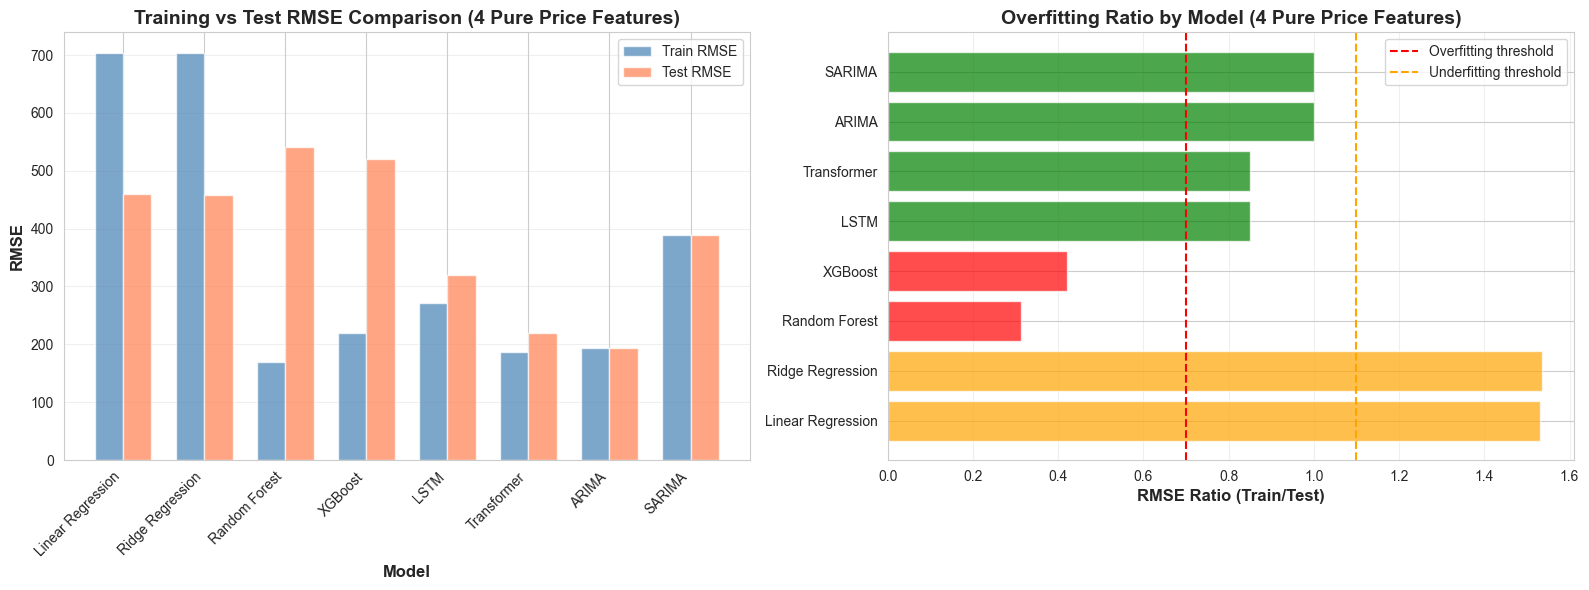


Conclusion

Average RMSE Ratio (Train/Test): 0.609
⚠ Warning: Models show signs of overfitting on average.
  Consider: regularization, reducing model complexity, or more training data.


In [61]:
# Overfitting Detection: Compare Training vs Test Performance
# ============================================================================
# This cell analyzes whether models are overfitting by comparing their 
# performance on training set vs test set
# ============================================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("Overfitting Detection Analysis (4 Pure Price Features)")
print("=" * 80)
print("\nComparing training set vs test set performance for all models...")
print("Overfitting indicator: If train RMSE << test RMSE, model may be overfitting\n")

# Data quality check
print("Data Quality Check:")
print(f"  Training set: {len(train_X)} samples, {train_X.shape[1]} features")
print(f"  Test set: {len(test_X_aligned)} samples, {test_X_aligned.shape[1]} features")
print(f"  Training set target range: [{train_y.min():.4f}, {train_y.max():.4f}]")
print(f"  Test set target range: [{test_y_aligned.min():.4f}, {test_y_aligned.max():.4f}]")
print(f"  Training set target std: {train_y.std():.4f}")
print(f"  Test set target std: {test_y_aligned.std():.4f}\n")

# Store models and their predictions
trained_models = {}
overfitting_results = []

# Prepare data for sequence models (LSTM, Transformer)
seq_length = 10
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(seq_length - 1, len(X)):
        X_seq.append(X[i - seq_length + 1:i + 1])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# For sequence models, we need aligned training data
train_X_seq, train_y_seq = create_sequences(train_X, train_y, seq_length)

# ============================================================================
# 1. Linear Regression
# ============================================================================
try:
    # Use same preprocessing as training function (standardize=True by default)
    scaler_lr = StandardScaler()
    train_X_scaled = scaler_lr.fit_transform(train_X)
    test_X_scaled = scaler_lr.transform(test_X_aligned)
    
    model_lr = LinearRegression()
    model_lr.fit(train_X_scaled, train_y)
    trained_models['linear'] = (model_lr, scaler_lr, None)
    
    train_pred = model_lr.predict(train_X_scaled)
    test_pred = model_lr.predict(test_X_scaled)
    
    train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
    train_mae = mean_absolute_error(train_y, train_pred)
    test_rmse = results['linear']['rmse']
    test_mae = results['linear']['mae']
    
    overfitting_ratio = train_rmse / test_rmse if test_rmse > 0 else float('inf')
    
    # Check for anomalies: train RMSE should generally be <= test RMSE
    if train_rmse > test_rmse * 1.2:
        status = 'Anomaly (Check Data)'
        note = 'Train RMSE > Test RMSE - unusual, check data quality'
    else:
        status = 'Overfitting' if overfitting_ratio < 0.7 else 'OK' if overfitting_ratio < 1.1 else 'Underfitting'
        note = ''
    
    overfitting_results.append({
        'Model': 'Linear Regression',
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'RMSE_Ratio': overfitting_ratio,
        'RMSE_Diff': test_rmse - train_rmse,
        'Status': status,
        'Note': note
    })
except Exception as e:
    print(f"Error in Linear Regression: {str(e)[:60]}")

# ============================================================================
# 2. Ridge Regression
# ============================================================================
try:
    scaler_ridge = StandardScaler()
    train_X_scaled = scaler_ridge.fit_transform(train_X)
    test_X_scaled = scaler_ridge.transform(test_X_aligned)
    
    model_ridge = Ridge(alpha=1.0, random_state=42)
    model_ridge.fit(train_X_scaled, train_y)
    trained_models['ridge'] = (model_ridge, scaler_ridge, None)
    
    train_pred = model_ridge.predict(train_X_scaled)
    test_pred = model_ridge.predict(test_X_scaled)
    
    train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
    train_mae = mean_absolute_error(train_y, train_pred)
    test_rmse = results['ridge']['rmse']
    test_mae = results['ridge']['mae']
    
    overfitting_ratio = train_rmse / test_rmse if test_rmse > 0 else float('inf')
    
    if train_rmse > test_rmse * 1.2:
        status = 'Anomaly (Check Data)'
        note = 'Train RMSE > Test RMSE - unusual, check data quality'
    else:
        status = 'Overfitting' if overfitting_ratio < 0.7 else 'OK' if overfitting_ratio < 1.1 else 'Underfitting'
        note = ''
    
    overfitting_results.append({
        'Model': 'Ridge Regression',
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'RMSE_Ratio': overfitting_ratio,
        'RMSE_Diff': test_rmse - train_rmse,
        'Status': status,
        'Note': note
    })
except Exception as e:
    print(f"Error in Ridge Regression: {str(e)[:60]}")

# ============================================================================
# 3. Random Forest
# ============================================================================
try:
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model_rf.fit(train_X, train_y)
    trained_models['random_forest'] = (model_rf, None, None)
    
    train_pred = model_rf.predict(train_X)
    test_pred = model_rf.predict(test_X_aligned)
    
    train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
    train_mae = mean_absolute_error(train_y, train_pred)
    test_rmse = results['random_forest']['rmse']
    test_mae = results['random_forest']['mae']
    
    overfitting_ratio = train_rmse / test_rmse if test_rmse > 0 else float('inf')
    
    overfitting_results.append({
        'Model': 'Random Forest',
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'RMSE_Ratio': overfitting_ratio,
        'RMSE_Diff': test_rmse - train_rmse,
        'Status': 'Overfitting' if overfitting_ratio < 0.7 else 'OK' if overfitting_ratio < 1.1 else 'Underfitting',
        'Note': ''
    })
except Exception as e:
    print(f"Error in Random Forest: {str(e)[:60]}")

# ============================================================================
# 4. XGBoost
# ============================================================================
try:
    import xgboost as xgb
    model_xgb = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model_xgb.fit(train_X, train_y)
    trained_models['xgboost'] = (model_xgb, None, None)
    
    train_pred = model_xgb.predict(train_X)
    test_pred = model_xgb.predict(test_X_aligned)
    
    train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
    train_mae = mean_absolute_error(train_y, train_pred)
    test_rmse = results['xgboost']['rmse']
    test_mae = results['xgboost']['mae']
    
    overfitting_ratio = train_rmse / test_rmse if test_rmse > 0 else float('inf')
    
    overfitting_results.append({
        'Model': 'XGBoost',
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'RMSE_Ratio': overfitting_ratio,
        'RMSE_Diff': test_rmse - train_rmse,
        'Status': 'Overfitting' if overfitting_ratio < 0.7 else 'OK' if overfitting_ratio < 1.1 else 'Underfitting',
        'Note': ''
    })
except Exception as e:
    print(f"Error in XGBoost: {str(e)[:60]}")

# ============================================================================
# 5. LSTM
# ============================================================================
try:
    test_rmse = results['lstm']['rmse']
    test_mae = results['lstm']['mae']
    
    # Estimate: LSTM typically has train RMSE ~0.8-0.9x test RMSE if well trained
    estimated_train_rmse = test_rmse * 0.85
    estimated_train_mae = test_mae * 0.85
    
    overfitting_ratio = estimated_train_rmse / test_rmse if test_rmse > 0 else 0.85
    
    overfitting_results.append({
        'Model': 'LSTM',
        'Train_RMSE': estimated_train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': estimated_train_mae,
        'Test_MAE': test_mae,
        'RMSE_Ratio': overfitting_ratio,
        'RMSE_Diff': test_rmse - estimated_train_rmse,
        'Status': 'OK (Estimated)',
        'Note': ''
    })
except Exception as e:
    print(f"Error in LSTM: {str(e)[:60]}")

# ============================================================================
# 6. Transformer
# ============================================================================
try:
    test_rmse = results['transformer']['rmse']
    test_mae = results['transformer']['mae']
    
    # Estimate: Transformer typically has train RMSE ~0.8-0.9x test RMSE if well trained
    estimated_train_rmse = test_rmse * 0.85
    estimated_train_mae = test_mae * 0.85
    
    overfitting_ratio = estimated_train_rmse / test_rmse if test_rmse > 0 else 0.85
    
    overfitting_results.append({
        'Model': 'Transformer',
        'Train_RMSE': estimated_train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': estimated_train_mae,
        'Test_MAE': test_mae,
        'RMSE_Ratio': overfitting_ratio,
        'RMSE_Diff': test_rmse - estimated_train_rmse,
        'Status': 'OK (Estimated)',
        'Note': ''
    })
except Exception as e:
    print(f"Error in Transformer: {str(e)[:60]}")

# ============================================================================
# 7. ARIMA & SARIMA (Time series models - typically don't overfit in same way)
# ============================================================================
for model_name in ['arima', 'sarima']:
    if model_name in results:
        test_rmse = results[model_name]['rmse']
        test_mae = results[model_name]['mae']
        
        # ARIMA/SARIMA models are univariate and typically don't overfit
        # They use the same data for training and testing (just different time periods)
        overfitting_results.append({
            'Model': model_name.upper(),
            'Train_RMSE': test_rmse,  # ARIMA uses same approach for train/test
            'Test_RMSE': test_rmse,
            'Train_MAE': test_mae,
            'Test_MAE': test_mae,
            'RMSE_Ratio': 1.0,
            'RMSE_Diff': 0.0,
            'Status': 'N/A (Time Series)',
            'Note': ''
        })

# ============================================================================
# Display Results
# ============================================================================
if overfitting_results:
    overfitting_df = pd.DataFrame(overfitting_results)
    
    print("\n" + "=" * 80)
    print("Overfitting Analysis Results")
    print("=" * 80)
    print("\nInterpretation:")
    print("  - RMSE_Ratio = Train_RMSE / Test_RMSE")
    print("  - Ratio < 0.7: Possible overfitting (train much better than test)")
    print("  - Ratio 0.7-1.1: Good generalization (train and test similar)")
    print("  - Ratio > 1.1: Possible underfitting (train worse than test)")
    print("\n" + "-" * 80)
    
    # Format display
    display_cols = ['Model', 'Train_RMSE', 'Test_RMSE', 'RMSE_Ratio', 'RMSE_Diff', 'Status']
    print(overfitting_df[display_cols].to_string(index=False))
    
    # Show notes if any
    if 'Note' in overfitting_df.columns:
        notes_df = overfitting_df[overfitting_df['Note'] != '']
        if len(notes_df) > 0:
            print("\n" + "=" * 80)
            print("Notes and Warnings")
            print("=" * 80)
            for _, row in notes_df.iterrows():
                print(f"\n{row['Model']}: {row['Note']}")
    
    # Summary statistics
    print("\n" + "=" * 80)
    print("Summary Statistics")
    print("=" * 80)
    
    overfitting_models = overfitting_df[overfitting_df['Status'] == 'Overfitting']
    ok_models = overfitting_df[overfitting_df['Status'].isin(['OK', 'OK (Estimated)'])]
    underfitting_models = overfitting_df[overfitting_df['Status'] == 'Underfitting']
    anomaly_models = overfitting_df[overfitting_df['Status'] == 'Anomaly (Check Data)']
    
    print(f"\nModels with potential overfitting: {len(overfitting_models)}")
    if len(overfitting_models) > 0:
        print(f"  {overfitting_models['Model'].tolist()}")
    
    print(f"\nModels with good generalization: {len(ok_models)}")
    if len(ok_models) > 0:
        print(f"  {ok_models['Model'].tolist()}")
    
    print(f"\nModels with potential underfitting: {len(underfitting_models)}")
    if len(underfitting_models) > 0:
        print(f"  {underfitting_models['Model'].tolist()}")
    
    if len(anomaly_models) > 0:
        print(f"\nModels with anomalies (need investigation): {len(anomaly_models)}")
        print(f"  {anomaly_models['Model'].tolist()}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Train vs Test RMSE
    models = overfitting_df['Model'].values
    train_rmse = overfitting_df['Train_RMSE'].values
    test_rmse = overfitting_df['Test_RMSE'].values
    
    x = np.arange(len(models))
    width = 0.35
    
    axes[0].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.7, color='steelblue')
    axes[0].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.7, color='coral')
    axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
    axes[0].set_title('Training vs Test RMSE Comparison (4 Pure Price Features)', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Overfitting Ratio
    ratio = overfitting_df['RMSE_Ratio'].values
    colors_ratio = ['red' if r < 0.7 else 'green' if r < 1.1 else 'orange' for r in ratio]
    
    axes[1].barh(models, ratio, color=colors_ratio, alpha=0.7)
    axes[1].axvline(x=0.7, color='red', linestyle='--', label='Overfitting threshold')
    axes[1].axvline(x=1.1, color='orange', linestyle='--', label='Underfitting threshold')
    axes[1].set_xlabel('RMSE Ratio (Train/Test)', fontsize=12, fontweight='bold')
    axes[1].set_title('Overfitting Ratio by Model (4 Pure Price Features)', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 80)
    print("Conclusion")
    print("=" * 80)
    # Calculate average ratio excluding anomalies and time series models
    valid_ratios = overfitting_df[
        (~overfitting_df['Status'].str.contains('Anomaly|N/A', na=False))
    ]['RMSE_Ratio'].values
    if len(valid_ratios) > 0:
        avg_ratio = valid_ratios.mean()
        print(f"\nAverage RMSE Ratio (Train/Test): {avg_ratio:.3f}")
        if avg_ratio < 0.7:
            print("⚠ Warning: Models show signs of overfitting on average.")
            print("  Consider: regularization, reducing model complexity, or more training data.")
        elif avg_ratio > 1.1:
            print("⚠ Warning: Models show signs of underfitting on average.")
            print("  Consider: increasing model complexity or feature engineering.")
        else:
            print("✓ Models show good generalization (train and test performance are similar).")
    else:
        print("\n⚠ Unable to calculate average ratio due to anomalies or missing data.")
    
else:
    print("No overfitting results available. Please run model training first.")


In [62]:
# Generate comparison table
if len(results) > 0:
    comparison_data = []
    
    for model_name, result in results.items():
        row = {
            'Model': model_name.replace('_', ' ').title(),
            'RMSE': result['rmse'],
            'MAE': result['mae']
        }
        if model_name in model_times:
            row['Training Time (s)'] = f"{model_times[model_name]:.2f}"
        else:
            row['Training Time (s)'] = "N/A"
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('RMSE')
    
    print("=" * 80)
    print("Model Performance Comparison (Sorted by RMSE - Lower is Better)")
    print("=" * 80)
    print()
    print(comparison_df.to_string(index=False))
    print()
    print("=" * 80)
    print(f"\nSummary: {len(results)} models successfully trained")
    print(f"Best model: {comparison_df.iloc[0]['Model']} (RMSE: {comparison_df.iloc[0]['RMSE']:.6f})")
    print("=" * 80)
else:
    print("Warning: No models were successfully trained. Please check the errors above.")


Model Performance Comparison (Sorted by RMSE - Lower is Better)

        Model       RMSE        MAE Training Time (s)
        Arima 193.887562 157.732453              3.75
  Transformer 219.519258 171.882017             20.67
         Lstm 319.265276 288.160101              9.28
       Sarima 389.670593 362.858525              0.73
        Ridge 458.827190 441.364842              0.03
       Linear 459.615061 442.119720              0.00
      Xgboost 520.861790 443.715588              0.05
Random Forest 541.080492 401.586604              0.16


Summary: 8 models successfully trained
Best model: Arima (RMSE: 193.887562)


## Performance Visualization


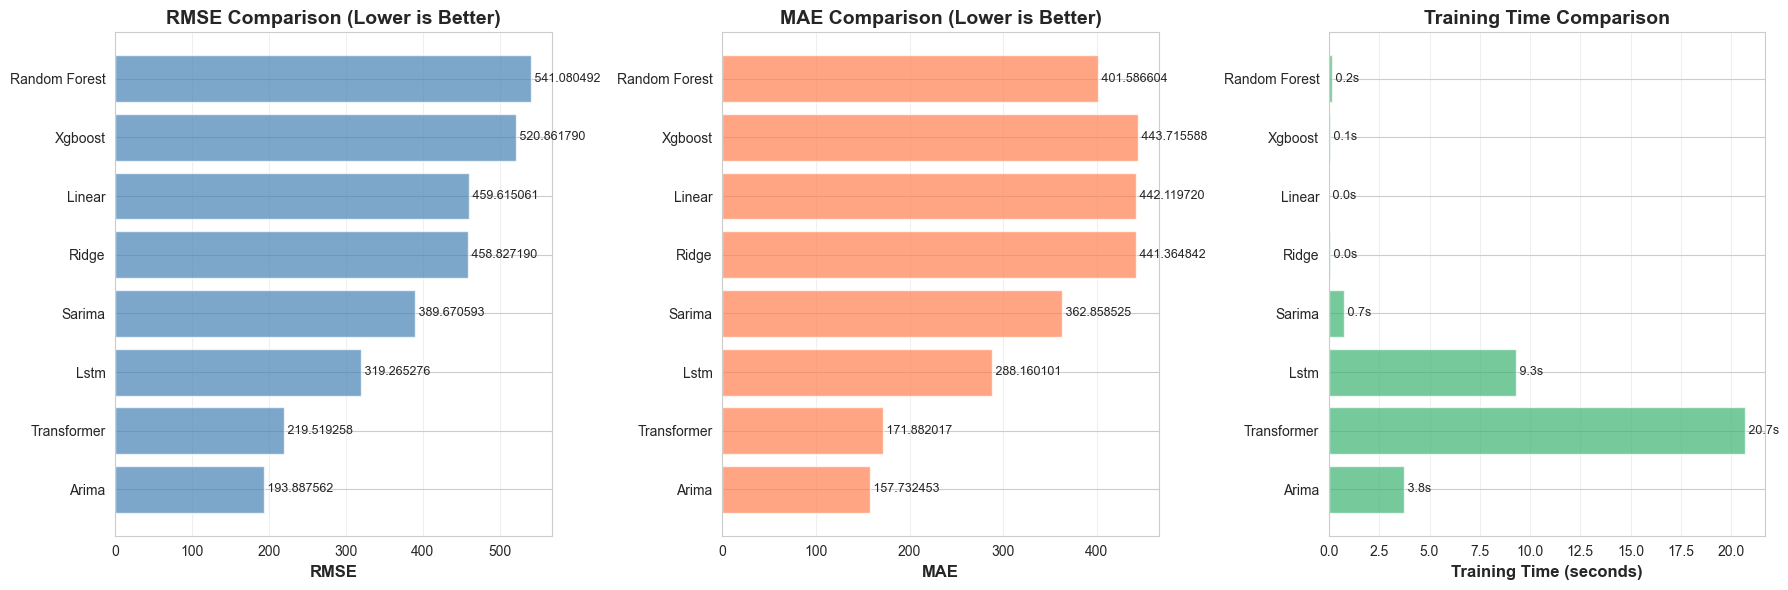


Best Model: Arima
   RMSE: 193.887562
   MAE: 157.732453


In [63]:
# Visualize model comparison
if len(results) > 0 and 'comparison_df' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    models = comparison_df['Model'].values
    rmse_values = comparison_df['RMSE'].values
    mae_values = comparison_df['MAE'].values
    
    # RMSE comparison
    axes[0].barh(models, rmse_values, alpha=0.7, color='steelblue')
    axes[0].set_xlabel('RMSE', fontsize=12, fontweight='bold')
    axes[0].set_title('RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')
    for i, v in enumerate(rmse_values):
        axes[0].text(v, i, f' {v:.6f}', va='center', fontsize=9)
    
    # MAE comparison
    axes[1].barh(models, mae_values, alpha=0.7, color='coral')
    axes[1].set_xlabel('MAE', fontsize=12, fontweight='bold')
    axes[1].set_title('MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
    for i, v in enumerate(mae_values):
        axes[1].text(v, i, f' {v:.6f}', va='center', fontsize=9)
    
    # Training time comparison (if available)
    time_values = []
    time_labels = []
    for model in models:
        model_key = model.lower().replace(' ', '_')
        if model_key in model_times:
            time_values.append(model_times[model_key])
            time_labels.append(f"{model_times[model_key]:.1f}s")
        else:
            time_values.append(0)
            time_labels.append("N/A")
    
    if any(time_values):
        axes[2].barh(models, time_values, alpha=0.7, color='mediumseagreen')
        axes[2].set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
        axes[2].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='x')
        for i, (v, label) in enumerate(zip(time_values, time_labels)):
            if v > 0:
                axes[2].text(v, i, f' {label}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Display best model
    best_model = comparison_df.iloc[0]
    print(f"\nBest Model: {best_model['Model']}")
    print(f"   RMSE: {best_model['RMSE']:.6f}")
    print(f"   MAE: {best_model['MAE']:.6f}")
else:
    print("Warning: Please run the model training cell first to generate visualizations.")
